# SWEEP

``sweep`` is a simple utility to evaluate a set of parameter values in serial (one at a time) or in parallel.  This set of parameter is stored in a CSV file.  ``sweep`` writes a new csv file with model-simulated values for observations listed in the control file.  Let's check it out...

The usual boiler plate to setup a model - in this case, we are using the freyberg hk + rch model

In [4]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu



In [5]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_KR
working_dir = fs.WORKING_DIR_KR
fs.setup_pest_kr()

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_kr
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/intro_to_sweep/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGIC

/Users/jwhite/Dev/python/pyemu/pyemu/pst/pst_utils.py:419: UserWarning: pst_from_io_files has moved to pyemu.helpers and is also now avaiable as a Pst class method (Pst.from_io_files())
  "now avaiable as a Pst class method (Pst.from_io_files())")


run():./inschek freyberg.travel.ins freyberg.travel
run():./inschek vol.dat.ins vol.dat
run():./pestchek freyberg_kr.pst
run():./pestpp freyberg_kr.init.pst


sweep accepts several optional ++ arguments in the control file:
- ++sweep_parameter_csv_file(): the name of the csv file for rows of parameter values
- ++sweep_output_csv_file(): the name of the csv file sweep writes with model outputs
- ++sweep_chunk(): how many parameter sets to evaluate before writing to the output csv file
each of these are optional - there are default values supplied if you don't pass them:
- ++sweep_parameter_csv_file = "sweep_in.csv"
- ++sweep_output_csv_file = "sweep_out.csv"
- ++sweep_chunk = 500


Let's make a csv file for sweep use and write some random values to it.  You can do this by hand in excel (!) or you embrace the sweetness that is python:

In [6]:
f =  open(os.path.join(working_dir,"my_first_sweep.csv"),'w')
    

First, we need to write a header to the sweep in file - listing the run id and the parameter names...
But wait!  We need to know the names of the parameter for the csv file header? How can get those?

In [9]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [10]:
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,log,factor,1.0,0.75,1.25,rch,1.0,0.0,1
rch_1,rch_1,log,factor,1.0,0.75,1.25,rch,1.0,0.0,1
hk,hk,log,factor,5.0,0.50,50.00,hk,1.0,0.0,1


In [11]:
f.write("run_id,rch_0,rch_1,hk\n")

22

Let's write one set of parameter values to this csv file, use whatever values you want...let's get crazy!

In [12]:
#you code here....
f.write("0,-999,-999,1.0E+30\n")

20

In [13]:
f.close()

Let's go look at the file "my_first_sweep.csv"

Cool...now let's run sweep! But from the command line, like real modelers!

Oh no!  Why didn't that work?  Remember, we named our input csv "my_first_sweep.csv", but the ``++sweep_parameter_csv_file()`` arg was not set, so ``sweep`` is looking for "sweep_in.csv".  So either rename your CSV file or add that optional arg to the control file and rerun...

In [14]:
pst.pestpp_options["sweep_parameter_csv_file"] = "my_first_sweep.csv"

In [15]:
pst.write(os.path.join(working_dir,pst_name))

Now go open up "sweep_out.csv".  What do you see?  If you used crazy parameter values, you have a failed run (look for a '0' or a '1' in the third column).  So ``sweep`` tracks run failures for you.  Let's fix the parameter values to be more reasonable and rerun sweep, this time all with python...

In [16]:
f =  open(os.path.join(working_dir,"my_first_sweep.csv"),'w')
f.write("run_id,rch_0,rch_1,hk\n")
f.write("0,0.004,0.002,3.14159\n")
f.close()
pyemu.helpers.run("sweep {0}".format(pst_name),cwd=working_dir)

run():sweep freyberg_kr.pst


In [17]:
df = pd.read_csv(os.path.join(working_dir,"sweep_out.csv"))
df

,run_id,input_run_id,failed_flag,phi,meas_phi,regul_phi,HEAD,FLX_CONSTAN,CALFLUX,VOL_RIVER_L,...,VOL_TOTAL_19750101,VOL_WELLS_19750101,VOL_CONSTAN_19750102,VOL_IN-OUT_19750102,VOL_PERCENT_19750102,VOL_RECHARG_19750102,VOL_RIVER_L_19750102,VOL_STORAGE_19750102,VOL_TOTAL_19750102,VOL_WELLS_19750102
0,0,0,0,309872.967274,309872.967274,0,0,0,297885.236824,0,...,-2,-4342481,408176.59375,-2,0,18202.921875,3913152,5328.991699,-2,-4344862.5


What do you see?  ``sweep`` is calculating the composite (total) objective function (``phi``), as well as the ``phi`` for each objective function component.  Then, past the ``phi`` info, are the simulated values for each observation listed in the control file.  Cool!

``sweep`` is total general and flexible, which lets you do all kinds of cool things with your PEST datasets, such as Monte Carlo or design of experiments.  All ``sweep`` does is run each row in the input CSV through the model and write the resulting simulated outputs to a new csv.  that it...

pyEMU interfaces nicely with ``sweep`` through the ``pandas.DataFrame`` object to let you easily generate and evaluate lots of parameter value combinations - Monte Carlo.  For demonstration purposes, let's do that...

In [19]:
pst.pestpp_options.pop("sweep_parameter_csv_file")
pst.write(os.path.join(working_dir,pst_name))
mc = pyemu.MonteCarlo(pst=pst)

In [20]:
mc.draw(100)

In [21]:
mc.parensemble

parnme,rch_0,rch_1,hk
0,0.820578,0.882861,23.8663
1,0.880715,0.987965,7.08621
2,0.998821,1.13687,4.89884
3,1.12646,0.914613,26.4012
4,0.931679,1.00492,0.962515
5,1.19226,1.04998,2.74019
6,0.795135,1.00562,4.82769
7,1.04276,0.935267,7.05936
8,0.798422,1.16524,22.4694
9,1.01254,1.19649,1.27029


Let's use ``pandas`` to write the CSV file we need

In [22]:
mc.parensemble.to_csv(os.path.join(working_dir,"sweep_in.csv"))

When execute this next block, go the terminal where the notebook is running and what the output...

In [23]:
pyemu.helpers.run("sweep {0}".format(pst_name),cwd=working_dir)

run():sweep freyberg_kr.pst


That was too slow...let's do it in parallel.  We are going to use a pyemu helper to start the parallel run manager that is built in to ``sweep``.  Don't worry about this for now, we will cover in much greater detail later...after executing this code block, go back to the terminal and watch

In [25]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"sweep",pst_name,num_slaves=10,master_dir='.')
os.chdir("..")

master:sweep freyberg_kr.pst /h :4004 in .
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_9


That was way faster...let's check out the results

In [26]:
df = pd.read_csv(os.path.join(working_dir,"sweep_out.csv"))
df

,run_id,input_run_id,failed_flag,phi,meas_phi,regul_phi,HEAD,FLX_CONSTAN,CALFLUX,VOL_RIVER_L,...,VOL_TOTAL_19750101,VOL_WELLS_19750101,VOL_CONSTAN_19750102,VOL_IN-OUT_19750102,VOL_PERCENT_19750102,VOL_RECHARG_19750102,VOL_RIVER_L_19750102,VOL_STORAGE_19750102,VOL_TOTAL_19750102,VOL_WELLS_19750102
0,0,0,0,5.576510e+03,5.576510e+03,0,0,0,1848.232866,0,...,869.0,-4348055.00,8.128781e+05,869.0,0.01,6307766.5,-2784622.000,1.528297e+04,869.0,-4350436.50
1,1,1,0,3.627229e+03,3.627229e+03,0,0,0,2777.263218,0,...,832.0,-4348055.00,-6.393127e+04,832.0,0.01,7058009.0,-2690779.000,4.796982e+04,832.0,-4350436.50
2,2,2,0,1.313972e+03,1.313972e+03,0,0,0,42.375907,0,...,869.0,-4348055.00,-2.730118e+05,868.0,0.01,8121081.0,-3571518.750,7.475409e+04,868.0,-4350436.50
3,3,3,0,2.033706e+04,2.033706e+04,0,0,0,17235.775636,0,...,1651.0,-4348055.00,9.060661e+05,1650.0,0.02,6536170.0,-3118223.500,2.807438e+04,1650.0,-4350436.50
4,4,4,0,6.836301e+04,6.836301e+04,0,0,0,920.192958,0,...,73.0,-3742250.00,-4.151496e+05,73.0,0.00,7179275.0,-3369320.500,3.495550e+05,73.0,-3744287.25
5,5,5,0,2.276907e+04,2.276907e+04,0,0,0,11590.211994,0,...,78.0,-4348055.00,-3.404620e+05,79.0,0.00,7502387.5,-3052309.000,2.408987e+05,79.0,-4350436.50
6,6,6,0,1.207610e+04,1.207610e+04,0,0,0,11233.994950,0,...,562.5,-4348055.00,-1.848948e+05,562.5,0.01,7183432.0,-2691316.000,4.377786e+04,562.5,-4350436.50
7,7,7,0,2.054829e+03,2.054829e+03,0,0,0,1321.589473,0,...,1315.5,-4348055.00,-3.397202e+04,1316.0,0.02,6683017.0,-2379499.000,8.220616e+04,1316.0,-4350436.50
8,8,8,0,7.100288e+03,7.100288e+03,0,0,0,3438.180588,0,...,311.0,-4348055.00,5.535219e+05,311.0,0.00,8322315.5,-4528853.000,3.763359e+03,311.0,-4350436.50
9,9,9,0,4.490906e+04,4.490906e+04,0,0,0,18.485887,0,...,24.0,-4011855.50,-5.166216e+05,24.0,0.00,8546547.0,-4255277.000,2.394097e+05,24.0,-4014034.50


Boom!  Monte Carlo done! In the next excersize, we will talk more about how this Monte Carlo is implemented and also what the results mean...

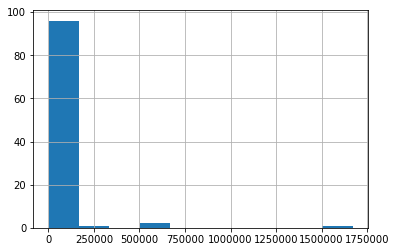

In [27]:
df.phi.hist(bins=10)